<a href="https://colab.research.google.com/github/Noomkwah/projet_python_2A_s1/blob/main/Copie_de_Copie_de_ProjetPython_RAYMONDjulien_DUPIREpaul_MASSINkeryann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Contexte :** Les énergies renouvelables sont au coeur des préoccupations environnementales de ces dernières décennies. La France dispose d'un taux d'ensoleillement de son territoire qui lui permet notamment d'exploiter l'énergie solaire. Cependant, la mise en place de panneaux solaires thermiques ou photovoltaïques présente des coûts incompressibles qu'il convient de prendre en compte. En particulier, les disparités d'ensoleillement et de températures selon les régions laissent présager que certaines régions sont plus propices à l'exploitation solaire que d'autres.

**Quelles sont les meilleures régions pour l'implantation de panneaux solaires photovoltaïques ?**

**Notre projet :** Ce projet tente de répondre à cette précédente question. Pour cela, on s'appuie sur une modélisation du rendement d'un panneau solaire photovoltaïque en fonction de différents paramètres tels que la température extérieure et la puissance reçue durant la journée.

# Librairies importées

On commence par importer toutes les librairies utiles.

In [ ]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import urllib.request
import urllib.error
import plotly.express as px
from google.colab import files


# Création de la base de donnée

La première étape du projet consiste en l'extraction des données utiles. On s'appuie pour cela sur l'API du [site de la commission européenne](https://re.jrc.ec.europa.eu). En particulier à partir de la base de données PVGIS. 

L’API donne accès pour chacun des points de coordonnées considéré à des variables d’intérets comme la puissance radiative reçue (“G(i)” en W/m2)  et la vitesse du vent (“WS10”, en m/s) pour une date donnée (Année-Mois-Jour-Heure). Les mesures sont réalisées de manière hebdomadaire.

Notre objectif est de réunir ces données en des variables moyennes sur une zone géographique choisie. 

In [ ]:
def extraction(latitude,longitude, startyear, endyear):
    """Extraction de la base de données pour les paramètres de longitudes, latitudes et de périodes
    à partir de l'API de la comission européenne https://re.jrc.ec.europa.eu"""
    
    req = "https://re.jrc.ec.europa.eu/api/seriescalc?lat="+str(latitude)+"&lon="+str(longitude)+"&startyear="+str(startyear)+"&endyear="+str(endyear)+"&month=0&showtemperatures=1&outputformat=csv&browser=1"
    url = urllib.request.urlopen(req) 
    return url

def normalisation(url, latitude,longitude):
    """On standardise les données récupérées pour les rendre comparables entre elles"""
    
    df_norm = pd.read_csv(url,skiprows=(8),skipfooter=9,engine='python') #On se débarasse des informations superflues
    
    df_norm['annee'] = df_norm['time'].str[:4] #On extrait la variable d'année à partir de la variable temps
    df_norm = df_norm.groupby(['annee'])['G(i)', 'WS10m'].mean() #On calcule la moyenne annuelle de la variable puissance radiative reçue et de la variable vitesse du vent
    df_norm['latitude'] = latitude #On rajoute les paramètres de latitude et de longitude
    df_norm["longitude"] = longitude

    return df_norm


In [ ]:
def creation_df_zone(latitude_1,latitude_2,longitude_1, longitude_2, precision,startyear,endyear):
    """Cette fonction sert à créer une base de données des moyennes de puissance radiative reçue et de vitesses du vent par an
        sur une zone géographique définie par ses paramètres de latitude et de longitude. 
        La variables précision donne la precision du quadrillage réalisé, type = int, > 0.
        Les variables startyear et endyear permettent de définir l'intervalle de temps considéré (2005-2016).
        Exemple : zone(1,2,-1,1,2,2010,2012)"""

    ls_df = [] #création d'une liste vide qui servira a réunir les bases de données années par années
    for longitude in range(longitude_1, (longitude_2+1), 1): #On parcourt un à un les longitude comprises entre longitude_1 et longitude_2
        for latitude in range(latitude_1*precision,(latitude_2+1)*precision,1): #On parcourt les latitudes selon le meme principe en affinant le  quadrillage à l'aide de la variable précision
            latitude = latitude/precision #La précision désigne le nombre de points supplémentaires 
            
            try :  #try permet de ne pas considérer les coordonnées manquantes (ex : océan). 
                url = extraction(latitude, longitude, startyear, endyear)#Récupération de la base de données brute
                df_norm = normalisation(url, latitude, longitude)#Standardisation de la base de données
                ls_df.append(df_norm)#Ajout de la base de données à la liste 
                
                
            except urllib.error.HTTPError:     #au cas où l'on tombe sur des lieux sans mesures, ignorer
                pass    
                
            
    df_final = pd.concat(ls_df, axis=0, ignore_index=False) #Concaténation des différents df (un par coordonnées)
    df_final.reset_index(level=0, inplace=True) #On enleve l'indexation par année
    
    
    
    
    df_final.to_csv('BaseDonneesEnsoleilementPythonDS.csv')  #Mettre le chemin d'accès et le nom du fichier avant le .csv    
    return df_final

**VISUALISATION DES DONNEES "BRUTES"**

In [ ]:
def carte_interactive(df,parametre):
    """Création d'une carte intéractive avec plotly, permet de visualiser les données
        Paramètre = "G(i)" [ensoleillement] ou "WS10m" [vitesse du vent]
        Il est nécessaire d'avoir construit le df d'abord au moyen de la fonction creation_df_zone
        
        Exemple : carte_interactive(df, "G(i)")
        """
    df["size"] = pd.Series([50 for x in range(len(df.index))])  #Création d'une variable de taille pour les 
    
    fig = px.scatter_mapbox(df.dropna(), #On se débarasse des valeurs manquantes
                        lat="latitude", #On donne les variables de coordonnées 
                        lon="longitude", 
                        color=str(parametre), #La couleur vient du parametre regardé : "G(i)" ou "WS10m"
                        size ="size", #La taille de chaque point
                        mapbox_style="carto-positron", #Le fond de carte
                        
                        #On joue avec les paramètres de légende pour les rendre cohérent avec les paramètres étudiés et consistants à travers le temps
                        color_continuous_scale=[[0, 'blue'], [0.15, 'green'],[0.30, "yellow"], [0.45, 'orange'], [0.60, 'pink'], [0.75, 'crimson'] ,[1.0, 'red']],
                        color_continuous_midpoint = df[parametre].mean(),
                        range_color=([df[parametre].min(),df[parametre].max()]),
                        zoom = 3,

                        #On anime le tout en fonction de l'année
                        animation_frame = 'annee')
    
    fig.show()

Il ne reste plus qu'à récupérer les données. La ligne ci-dessous s'en occupe. Son exécution est assez longue (13 minutes depuis Google Colab, sur un Core AMD Ryzen 5). Notez que le résultat de cette ligne est déjà enregistré dans le github du projet. Il suffit de l'importer en utilisant le lien csv ci-après.

In [ ]:
df = creation_df_zone(41,52,-6,10,2,2013,2016) #On crée la base de données sur le territoire de France métropolitaine

<ipython-input-2-402f5e9a3187>:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_norm = df_norm.groupby(['annee'])['G(i)', 'WS10m'].mean() #On calcule la moyenne annuelle de la variable puissance radiative reçue et de la variable vitesse du vent


KeyboardInterrupt: ignored

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Noomkwah/projet_python_2A_s1/main/BD_G(i).csv', index_col = 0)
df.head()

,annee,G(i),WS10m,latitude,longitude
0,2013,192.259062,3.304105,41.0,-6
1,2014,195.657178,3.172605,41.0,-6
2,2015,197.981887,2.955639,41.0,-6
3,2016,187.812598,3.534647,41.0,-6
4,2013,190.524902,3.312728,41.5,-6


In [ ]:
carte_interactive(df,"G(i)")

In [ ]:
df.sample(10)

,annee,G(i),WS10m,latitude,longitude,size
125,2014,153.288764,2.467200,44.0,-1,50
498,2015,149.444917,3.319015,47.5,3,50
191,2016,106.671456,5.087653,54.0,-1,50
272,2013,121.680629,3.520871,49.0,0,50
826,2015,131.382579,3.283612,49.5,7,50
873,2014,85.062300,2.946023,60.0,7,50
202,2015,195.905377,3.589591,40.0,0,50
389,2014,159.151521,2.972715,43.0,2,50
550,2015,157.331596,2.571890,45.5,4,50
405,2014,150.850477,2.898603,45.0,2,50


La base de donnée ainsi formée renseigne pour chaque latitude (précision  de 0.5 degré) et chaque longitude (précision de 1 degré) 

# Modélisation

Afin de pouvoir juger de la rentabilité d'un panneau solaire, nous allons donc devoir quantifier la puissance fournie par le panneau solaire. Pour celà nous allons utiliser une base de données intitulé "Solar Power Generation Data" de Ani Kannal du site Kaggle : https://www.kaggle.com/datasets/anikannal/solar-power-generation-data?select=Plant_2_Weather_Sensor_Data.csv 

Nous extrayons ci-dessous les bases de données.
Nous notons :
* dfG1 la base de données relatives au performance du panneau solaire numéro 1, renseignant variables AC_POWER (puissance produite par le panneau)
* dfW1 la base de données relatives aux conditions météorologiques qu'a subi le panneau numéro 1 sur les mêmes périodes, qui renseigne les variables AMBIENT_TEMPERATURE (température extérieure), MODULE_TEMPERATURE (température du capteur solaire) et IRRADIATION (puissance radiative reçue par le panneau).

De même, dfG2 et dfW2 correspondent aux mêmes bases de données en ce qui concerne le panneau numéro 2.

Dans la suite, nous allons établir nos modèles sur les données du panneau numéro 1 et comparerons nos résultats aux données du panneau numéro 2.

In [ ]:
dfG1 = pd.read_csv('https://raw.githubusercontent.com/Noomkwah/projet_python_2A_s1/main/Plant_1_Generation_Data_.csv')
dfW1 = pd.read_csv('https://raw.githubusercontent.com/Noomkwah/projet_python_2A_s1/main/Plant_1_Weather_Sensor_Data.csv')
dfG2 = pd.read_csv('https://raw.githubusercontent.com/Noomkwah/projet_python_2A_s1/main/Plant_2_Generation_Data_.csv')
dfW2 = pd.read_csv('https://raw.githubusercontent.com/Noomkwah/projet_python_2A_s1/main/Plant_2_Weather_Sensor_Data.csv')

In [ ]:
dfG1.sample(10)

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
46362,07-06-2020 08:45,4135001,3PZuoBAID5Wc2HD,5063.142857,496.542857,590.000000,7159572.000
34048,01-06-2020 10:30,4135001,iCRJl6heRkivqQ3,11584.285710,1130.300000,2234.857143,7306801.857
68553,17-06-2020 21:15,4135001,uHbuxQJl8lW7ozc,0.000000,0.000000,5967.000000,7287002.000
57777,12-06-2020 18:15,4135001,zVJPv84UY57bAof,363.625000,35.150000,5857.000000,7328544.000
65103,16-06-2020 05:30,4135001,zVJPv84UY57bAof,0.000000,0.000000,0.000000,7351100.000
19752,25-05-2020 06:15,4135001,pkci93gMrogZuBj,439.714286,42.528571,3.428571,7241710.429
8801,19-05-2020 07:45,4135001,YxYtjZvoooNbGkE,3281.857143,322.300000,253.285714,7205851.286
21407,26-05-2020 01:00,4135001,z9Y9gH1T5YWrNuG,0.000000,0.000000,0.000000,7089440.000
55542,11-06-2020 17:00,4135001,ZnxXDlPa8U1GXgE,2414.375000,236.750000,5531.500000,6729741.500
26671,28-05-2020 14:00,4135001,rGa61gmuvPhdLxV,7520.750000,735.475000,6218.750000,7212767.750


**Partie 1 : Nettoyage des données.**
Dans un premier temps, nous allons nous concentrer sur le traitement des données du panneau numéro 1, puis nous effeturons le même traitement sur les données du panneau numéro 2 un peu plus tard.

 Pour utiliser ces bases de données, la première chose à faire est de les nettoyer. On commence par retravailler les données temporelles pour qu'elles soient toutes au format jj/mm/aaaa hh:mm.

In [ ]:
def ref_time(dfW):
    vect_time=[]
    for i in range(dfW.shape[0]):
        a = dfW['DATE_TIME'][i]
        vect_time.append(a[8:10]+a[4:8]+a[:4]+' '+a[11:16])

    dfW['DATE_TIME']=np.array(vect_time).tolist()

ref_time(dfW1) # Formatage des données temporelles


La deuxième étape consiste à supprimer les lignes qui ne sont pas à la fois dans dfG et dans dfW.

In [ ]:
def epuration(dfG,dfW):
    dateG = list(dfG['DATE_TIME'].to_numpy())
    dateW = list(dfW['DATE_TIME'].to_numpy())

    LW,LG=[],[]

    for i in range(len(dateW)):
        if dateW[i] not in dateG:
            LW.append(i)
    for i in range(len(dateG)):
        if dateG[i] not in dateW:
            LG.append(i)

    dfG_=dfG.drop(LG).reset_index().drop(columns=["index"])
    dfW_=dfW.drop(LW).reset_index().drop(columns=["index"])

    return dfG_,dfW_

dfG1,dfW1 = epuration(dfG1,dfW1)

On s'occupe ensuite de dupliquer les données jointes afin d'aligner chaque date de dfW à la date de dfG correspondante.

In [ ]:
def dupli_join(dfG,dfW):

    #duplication des données de dfW pour s'aligner à dfG
    v = dfW['DATE_TIME'].to_numpy()
    for time in v:
        index = np.where(v==time)
        df_try = dfW.loc[index]
        d=dfG.where(dfG['DATE_TIME']==time, inplace=False).count()['DATE_TIME']
        for j in range(d-1):
            dfW=dfW.append(df_try)

    #tri sur l'order alphabétique des dates :
    dfW = dfW.sort_values(by=['DATE_TIME'])
    dfG = dfG.sort_values(by=['DATE_TIME'])

    #Jointure indirecte sur les dates
    dfG['Jointure'] = list(range(dfG.shape[0]))
    dfW['Jointure'] = list(range(dfW.shape[0]))

    df = pd.merge(dfG,dfW,on='Jointure')
    return df
    
df1 = dupli_join(dfG1,dfW1)

On peut alors construire la base de données finale "df1rl" qui comporte les variables DATE_TIME_x (la date et l'horaire en format jj/mm/aaaa hh:mm) ; AC_POWER ; IRRADIATION ; AMBIENT_TEMPERATURE ; MODULE_TEMPERATURE ; Delta_T ( différence entre MODULE_TEMPERATURE et AMBIENT_TEMPERATURE) ; et Delta_T2 (le carré de Delta_T).

Ce sont ces variables qui vont nous permettre de modéliser la puissance fournit par le capteur.

In [ ]:
df1rl = df1[['DATE_TIME_x','AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION','AC_POWER']]

df1rl['AC_POWER']=df1rl['AC_POWER']*10**(-4)*10**3 #pour ramener de kW à l'hectare en W au mètre carré
df1rl['IRRADIATION']=df1rl['IRRADIATION']*10**3 #pour ramener de kW en W

df1rl['Delta_T']=df1rl['MODULE_TEMPERATURE']-df1rl['AMBIENT_TEMPERATURE']

df1rl['Delta_T2']= df1rl['Delta_T'] ** 2

<ipython-input-13-0424ba8449bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1rl['AC_POWER']=df1rl['AC_POWER']*10**(-4)*10**3 #pour ramener de kW à l'hectare en W au mètre carré
<ipython-input-13-0424ba8449bc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1rl['IRRADIATION']=df1rl['IRRADIATION']*10**3 #pour ramener de kW en W
<ipython-input-13-0424ba8449bc>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

**Partie 2 : Modélisation de la différence de température entre capteur et extérieur.** 

Nous voulons modéliser la puissance fournie par le panneau solaire en fonction de l'irradiation et de la différence de température entre le capteur solaire et l'extérieur.

Comme la base de données de la commission européenne ne nous donne pas la température des capteurs, nous allons dans un premier temps tenter de modéliser cette différence de température Delta_T.

Pour celà, nous avons décider de considérer Delta_T comme une fonction du temps au cours de la journée.

In [ ]:
def minutes(dfrl):
    c= []
    for i in range(len(dfrl['DATE_TIME_x'])):
        t = int(dfrl['DATE_TIME_x'][i][14:]) + 60*(int(dfrl['DATE_TIME_x'][i][11:13]))
        c.append(t)

    dfrl['minutes']=c

minutes(df1rl)

def g(x):
    """
    Au vu des données, nous allons supposer que Delta_T  = f(minutes journalière) est une fonction symétrique centré en 720,
    les resultats de cette transformation seront nommées "minutes ajustées" (en minutes carrées)
    """
    return (x - 720)**2

df1rl['minutes_ajustées'] = df1rl['minutes'].apply(g)

<ipython-input-14-3544c57a62a2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfrl['minutes']=c
<ipython-input-14-3544c57a62a2>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1rl['minutes_ajustées'] = df1rl['minutes'].apply(g)


Le code ci-dessous permet de construire un graphique des données.

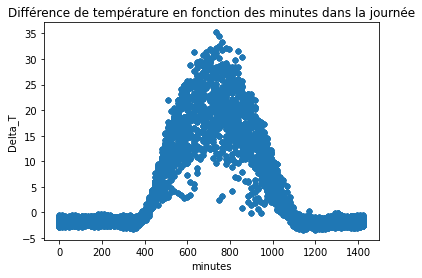

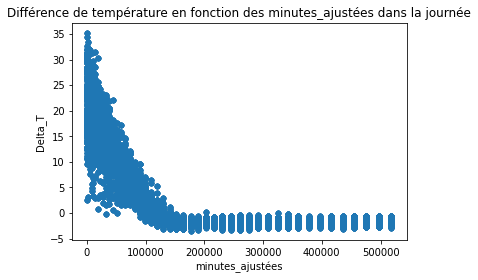

In [ ]:
def graphes(labelX,labelY,titre,size=0.5):
    df1rl.plot.scatter(x=labelX, y=labelY, alpha=size)
    plt.title(titre)
    plt.show()

graphes('minutes','Delta_T','Différence de température en fonction des minutes dans la journée')
graphes('minutes_ajustées','Delta_T','Différence de température en fonction des minutes_ajustées dans la journée')

La forme que prennent les données sur le premier graphique, nous permettent de supposer que Delta_T suit une loi de forme gaussienne au cours du temps :

$\hat{\Delta T} = \exp(-\frac{1}{w}(m-720)^{2} + b_{1}) + b_{2} $ 

$\hat{\Delta T}$ :  la différence entre températures du capteur et extérieure estimée (en K)

m : le temps au cours d'une journée (en min)


Le deuxième graphique ci-dessus présente Delta_T en fonction des "minutes ajustées" c'est-à-dire selon $(m - 720)^{2}$.

Nous allons donc chercher à déterminer $w, b1$ et $b2$ de façon à approximer la relation entre Delta_T et les "minutes ajustées" en utilisant la fonction minimize de la librairie $scipy$.


In [ ]:
def f_opt(coeff):
    """
    Nous prenons un modele de la forme Delta_T = exp ( x/w + b1 ) + b2 où x : minutes ajustées.
    Nous cherchons alors w,b1,b2 qui réduit la mse (Mean Square Error)
    """
    [w,b1,b2] = coeff
    Y = df1rl['Delta_T'].to_numpy() #target
    PY = np.exp(-df1rl['minutes_ajustées'].to_numpy()*(1/w) + b1) + b2 #prediction
    return np.mean((Y - PY)**2)

res = minimize(f_opt,[10**4,3,0])

def f(x):
    """ Fonction optimale pour le modèle pris """
    [w,b1,b2] = list(res['x'])
    return np.exp(-x/w + b1) + b2

df1rl['prediction_dtemp'] = df1rl['minutes_ajustées'].apply(f)


<ipython-input-16-8caa9ea92377>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1rl['prediction_dtemp'] = df1rl['minutes_ajustées'].apply(f)


Nous pouvons ainsi observer ci-dessous la relation entre Delta_T et les "minutes ajustées" avec en orange notre prédiction :

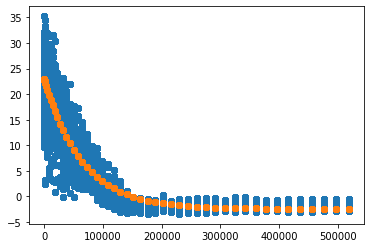

In [ ]:
plt.scatter(df1rl['minutes_ajustées'].to_numpy(),df1rl['Delta_T'].to_numpy())
plt.scatter(df1rl['minutes_ajustées'].to_numpy(),df1rl['prediction_dtemp'])
plt.show()

De même, on peut ensuite observer la relation entre Delta_T et les minutes au cours d'une journée avec en orange notre prédiction :

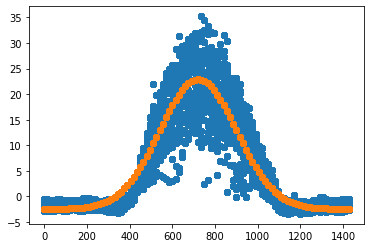

In [ ]:
plt.scatter(df1rl['minutes'].to_numpy(),df1rl['Delta_T'].to_numpy())
plt.scatter(df1rl['minutes'].to_numpy(),df1rl['prediction_dtemp'])
plt.show()

Nous constatons que l'approximation de notre modèle est plutôt bonne.

Nous allons désormais réaliser le même traitement que sur les données du panneau numéro 1 sur les données du panneau numéro 2, afin de vérifier sur notre modèle tient la route. (4 min)

<ipython-input-17-dc8300206f22>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2rl['AC_POWER'] = df2rl['AC_POWER']*10**(-4)*10**3
<ipython-input-17-dc8300206f22>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2rl['IRRADIATION']=df2rl['IRRADIATION']*10**3
<ipython-input-17-dc8300206f22>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

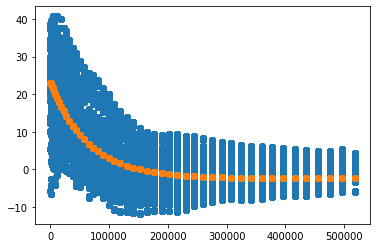

In [ ]:
ref_time(dfW2)
ref_time(dfG2)
dfG2,dfW2 = epuration(dfG2,dfW2)
df2 = dupli_join(dfG2,dfW2)
df2rl = df2[['DATE_TIME_x','AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE',
       'IRRADIATION','AC_POWER']]
df2rl['AC_POWER'] = df2rl['AC_POWER']*10**(-4)*10**3
df2rl['IRRADIATION']=df2rl['IRRADIATION']*10**3
df2rl['Delta_T']=df2rl['MODULE_TEMPERATURE']-df1rl['AMBIENT_TEMPERATURE']
df2rl['Delta_T2']= df2rl['Delta_T'] ** 2
minutes(df2rl)
df2rl['minutes_ajustées'] = df2rl['minutes'].apply(g)
df2rl['prediction_dtemp'] = df2rl['minutes_ajustées'].apply(f)

plt.scatter(df2rl['minutes_ajustées'].to_numpy(),df2rl['Delta_T'].to_numpy())
plt.scatter(df2rl['minutes_ajustées'].to_numpy(),df2rl['prediction_dtemp'])
plt.show()

Nous observons une erreur due au fait que les données de Delta_T du panneau numéro 2 ne sont pas aussi symétriques par rapport au temps que celles du panneau numéro 2, nous nous permettrons néamoins de conserver cette hypothèse et ce modèle pour la suite.

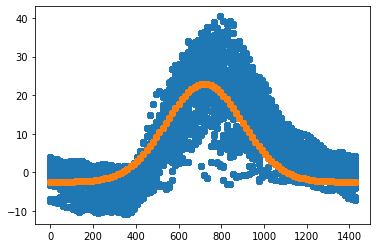

In [ ]:
plt.scatter(df2rl['minutes'].to_numpy(),df2rl['Delta_T'].to_numpy())
plt.scatter(df2rl['minutes'].to_numpy(),df2rl['prediction_dtemp'])
plt.show()

**Partie 3 : Modelisation de la puissance fournie par un panneau solaire.** 

Maintenant que nous avons obtenu une modélisation de la différence de température entre le capteur solaire et l'extérieur (Delta_T) que nous pourrons appliquer sur la base de données de la commission européenne. 

Nous allons pouvoir nous concentrer sur la modélisation de la puissance fournie par le panneau solaire en fonction de la puissance reçue et de cette différence de températures.

Pour se faire, nous allons considérer la régression linéaire suivante en utilisant la librairie $sklearn$ :


$\hat{P} = \alpha + \beta_0 G + \beta_1 \Delta T + \beta_2 \Delta T^{2} $

$\hat{P}$ : puissance fournie par le panneau estimée (en W/m²)

G : puissance reçue par le panneau (en W/m²)

$\Delta T$ : la différence entre températures du capteur \newline
et extérieure (en K)

In [ ]:
def RL(X_train,Y_train,X_test,Y_test):
    """
    Fonction de regression linéaire
    """
    x_train = X_train.to_numpy()
    y_train = Y_train.to_numpy()
    x_test = X_test.to_numpy()
    y_test = Y_test.to_numpy()

    # Création du modèle
    model_linRegMul = LinearRegression()

    # Entrainement du modèle
    model_linRegMul.fit(x_train, y_train)

    # Précision du modèle
    precision_train = model_linRegMul.score(x_train, y_train)
    precision_test = model_linRegMul.score(x_test, y_test)
    print('accuracy_train =',precision_train)
    print('accuracy_test =',precision_test)

    # Coefficient du modèle
    print('cons_ =', model_linRegMul.intercept_)
    print('coeff_ =',model_linRegMul.coef_)
    a=model_linRegMul.intercept_[0]
    b=model_linRegMul.coef_[0]

    return a,b

In [ ]:
# Modele de la RL : P_fournie = f(Delta_T, Delta_T2, IRRADIATION)
alpha,beta = RL(df1rl[['Delta_T', 'Delta_T2','IRRADIATION']],df1rl[['AC_POWER']],df2rl[['Delta_T', 'Delta_T2','IRRADIATION']],df2rl[['AC_POWER']])

accuracy_train = 0.9814148857467186
accuracy_test = 0.5105336269804521
cons_ = [1.28937272]
coeff_ = [[ 0.7596788  -0.02660441  0.12258335]]


Enfin il ne reste plus qu'à construire et visualiser les prédictions. Nous pouvons pour commencer observer ci-dessous les relations entre la puissance fournie par le panneau (AC_POWER) et les différentes variables que nous allons utiliser  pour l'expliquer dans la régression, à savoir la puissance reçue (IRRADIATION), la différence des températures (Delta_T) et le carré de cette différence (Delta_T2) :

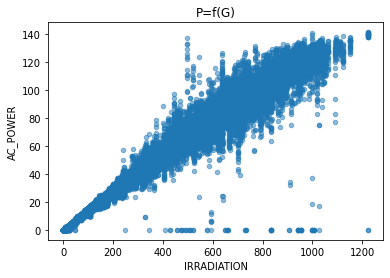

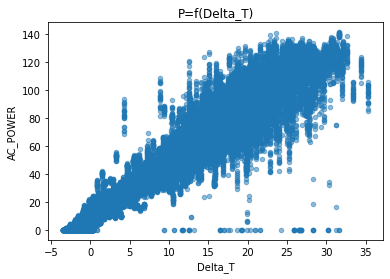

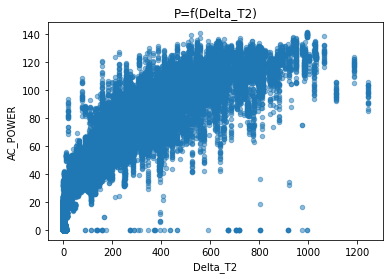

<ipython-input-25-90328320a58f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2rl['Y']=alpha + beta[0]*df2rl['Delta_T']+beta[1]*df2rl['Delta_T2']+beta[2]*df2rl['IRRADIATION']


In [ ]:
# Visualisation des données
graphes("IRRADIATION","AC_POWER",'P=f(G)')
graphes("Delta_T", "AC_POWER",'P=f(Delta_T)')
graphes("Delta_T2", "AC_POWER",'P=f(Delta_T2)')

# Construction de la prediction
df1rl['Y']=alpha + beta[0]*df1rl['Delta_T']+beta[1]*df1rl['Delta_T2']+beta[2]*df1rl['IRRADIATION']
df2rl['Y']=alpha + beta[0]*df2rl['Delta_T']+beta[1]*df2rl['Delta_T2']+beta[2]*df2rl['IRRADIATION']

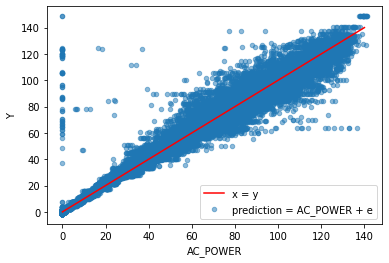

In [ ]:
# Visualisation de la prédiction sur df1rl
df1rl.plot.scatter(x="AC_POWER", y="Y", alpha=0.5, label="prediction = AC_POWER + e")
plt.plot([0,140],[0,140], label="x = y",color='r')
plt.legend()
plt.show()

Ci-dessus, nous pouvons observer la relation entre la puissance fournie par le panneau numéro 1 (AC_POWER) et notre prédiction de cette puissance (ici notée Y).
Nous avons ainsi une accuracy supérieur à 0.98 par rapport aux données du panneau numéro 1 (qui sont aussi les données d'entrainement).

Nous allons ci-dessous, observer la relation entre la puissance fournie et la prédiction pour le panneau numéro 2 (les données de tests) :

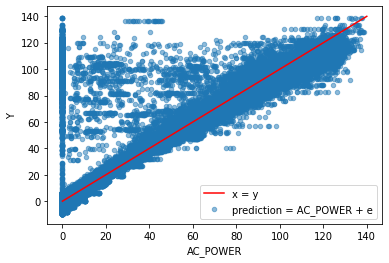

In [ ]:
# Visualisation de la prédiction sur df2rl
df2rl.plot.scatter(x="AC_POWER", y="Y", alpha=0.5, label="prediction = AC_POWER + e")
plt.plot([0,140],[0,140], label="x = y",color='r')
plt.legend()
plt.show()

Avec une accuracy de près de 0.5, nous constatons que notre modèle n'est pas parfait.

 Par ailleurs nous avons observée qu'en échangeant le role de base de données d'entrainement et test, l'accuracy pour le panneau numéro 2 et numéro 1 est respectivement de 0.62 et de 0.89. Le biais ne vient donc pas uniquement de la base de données d'entrainement, mais aussi de la grande disparité des données du panneau numéro 2.

 Au final, nous avons décider de conserver notre modèle ayant les données du panneau numéro 1 en données d'entrainement.

Afin d'éviter de reconstruire le modèle de A à Z à chaque fois, voici les résultats que nous avons obtenu pour la régression linéaire :


In [ ]:
alpha = 1.28937272 
beta = [0.7596788, -0.02660441, 0.12258335]

Et pour la modélisation de la différence de températures en fonction de la minute au cours de la journée voici $g$ et $f$ tel que 

$\hat{\Delta T} = f \circ g(m) = \exp(-\frac{1}{w}(m-720)^{2} + b_{1}) + b_{2}$

où

$g : m ⟶ (m - 720)^{2}$ : le passage des minutes aux "minutes ajustées"

et

$f : m_{aj} ⟶ \exp(-\frac{m_{aj}}{w} + b_{1}) + b_{2}$


In [ ]:
def g(x):
    """
    Au vu des données, nous allons supposer que Delta_T  = f(minutes journalière) est une fonction symétrique centré en 720,
    les resultats de cette transformation seront nommées "minutes ajustées" (en minutes carrées)
    """
    return (x - 720)**2

def f(x):
    """ Fonction optimale pour le modèle pris """
    [w,b1,b2] = [ 6.45260113e+04,  3.23363775e+00, -2.44429761e+00]
    return np.exp(-x/w + b1) + b2

Finalement, nous avons un modèle qui nous permet d'estimer la différence de température entre l'extérieure et le capteur solaire ainsi qu'un modèle nous permettant de prédire la puissance fournie par le panneau à partir de la puissance reçue et de la différence des températures.

Nous allons donc pouvoir appliquer ces modèles aux données de la base de la commission européenne et visualiser les résultats.

# Visualisation des données

Dans cette partie, nous allons chercher à visualiser trois variables qui nous permettrons de juger de la perfomance d'un panneau solaire en fonction de sa position géographique.
Nous allons donc les modéliser à partir des données de la commission européenne, les voici :     
1/ La puissance fournie estimée par mètre carré : $\hat{P}$

2/ Le rendement annuel : $\hat{\eta} = \frac{\int_{t}^{t+1} \hat{P} dt}{\int_{t}^{t+1} G dt}$, 

Il s'agit du rapport entre l'énérgie fournie par le panneau entre l'année $t$ et l'année $t+1$ ($\int_{t}^{t+1} \hat{P} dt$) et l'énergie reçue par le soleil sur cette même période ($\int_{t}^{t+1} G dt$).

3/ Et le taux de retour énergétique : $\frac{\int \hat{P} dt}{E_{0}}$

Il s'agit du rapport entre l'énergie que le panneau tout au long de sa vie ($\int \hat{P} dt$) et l'énergie qui a due être mobilisée pour construire un mètre carré de panneau ($E_{0}$)

Nous en dirons un peu plus sur le taux de retour énergétique dans la suite.



Note1 : Pour la suite nous considérerons qu'un panneau solaire à une espérance de vie de 25 ans (temps écoulé entre son installation et son démentellement) et qu'un mètre carré de panneau solaire demande la mobilisation de 420 kWh, ainsi : $E_{0}$ = 420 kWh/m².



Nous allons commencer par appliquer le modèle que nous venons de construire sur notre base de données principale, en redéfinissant la fonction "normalisation" de la partie 'Création de la base de données' : (environ 20 min)

Note2 : seules les deux dernières case de code de la partie modélisation peuvent être computée pour faire fonctionner le code suivant (il est néanmoins nécessaire de computer les fonctions des parties précédentes).

Note3 : Nous avons au préalable enregistrée la base de données sur GitHub afin d'éviter de recalculer creation_df_zone comme nous l'avons fait dans la partie "Création de la base de données".

In [ ]:
from _plotly_utils.colors.diverging import delta
def normalisation(url, latitude,longitude):
    """On standardise les données récupérées pour les rendre comparables entre elles"""


    delta_t = 1 # = 1 heure (notre précision temporelle)

    df_norm = pd.read_csv(url,skiprows=(8),skipfooter=9,engine='python') #On se débarasse des informations superflues

    df_norm['annee'] = df_norm['time'].str[:4] #On extrait la variable d'année à partir de la variable temps

    #transformation en minutes
    c = []
    for i in range(len(df_norm)):
        c.append(int(df_norm['time'][i][9:11])*60 + int(df_norm['time'][i][11:]))
    df_norm['minutes']=c

    #construction de Delta_T
    df_norm['Delta_T'] = df_norm['minutes'].apply(g).apply(f)
    df_norm['Delta_T2'] = df_norm['Delta_T']**2

    #construction de P_fournie
    df_norm['P_fournie'] = alpha + beta[0]*df_norm['Delta_T'] + beta[1]*df_norm['Delta_T2']+beta[2]*df_norm['G(i)']
    df_norm['Energie_recue'] = df_norm['G(i)']*delta_t #en Wh par m2
    df_norm['Energie_fournie'] = df_norm['P_fournie']*delta_t #en Wh par m2
    df_norm['rendement'] = df_norm['Energie_fournie'] / df_norm['Energie_recue']


    df_norm = df_norm.groupby(['annee'])['Energie_recue', 'Energie_fournie'].sum() 
    df_norm['latitude'] = latitude 
    df_norm['longitude'] = longitude
    df_norm['rendement_annuel'] = df_norm['Energie_fournie'] / df_norm['Energie_recue'] #Construction du rendement annuel
    df_norm['retour_énergétique'] = 25/420000 * df_norm['Energie_fournie'] #Construction du taux de retour énergétique

    return df_norm



In [ ]:
df = creation_df_zone(41,52,-6,10,2,2013,2016) #On recrée la base de données sur le territoire de France métropolitaine
#20min30

<ipython-input-10-829005142192>:29: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_norm = df_norm.groupby(['annee'])['Energie_recue', 'Energie_fournie'].sum()


Nous pouvons donc désormais visualiser l'énergie fournie par un mètre carré de panneau solaire ainsi que le rendement obtenue pour chaque point de l'espace considéré en France Métropolitaine.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Noomkwah/projet_python_2A_s1/main/BD_norm.csv', index_col=0)
df.head()

,annee,Energie_recue,Energie_fournie,latitude,longitude,rendement_annuel,retour_énergétique
0,2013,1684189.38,228747.144093,41.0,-6,0.135820,13.615901
1,2014,1713956.88,232396.143964,41.0,-6,0.135590,13.833104
2,2015,1734321.33,234892.486466,41.0,-6,0.135438,13.981696
3,2016,1649745.86,224586.020293,41.0,-6,0.136134,13.368215
4,2013,1668998.14,226884.951003,41.5,-6,0.135941,13.505057


In [ ]:
carte_interactive(df,"Energie_fournie")
carte_interactive(df,"rendement_annuel")

Nous pouvons premièrement noter que les régions de France ayant plus d'Energie fournie (ce qui est corrélé à l'Energie reçue vu précédemment) correspondent également aux zone ayant le moins bon rendement estimé (bien que la différence se joue au point de pourcentage près).

Ceci est essentiellement dû à la construction de notre estimateur de rendement qui décroît avec la puissance radiative reçue.

Par ailleurs, nous constatons qu'un mètre carré de panneaux solaires peut produire jusqu'à 220 kWh dans l'année. Or nous savons que pour produire une telle surface, sans tenir compte du transport, il est nécessaire de mobiliser $E_{0} = 420 kWh$.


Nous en déduisons que d'un point de vue énergétique, ces panneaux solaires là deviennent rentable à partir de la troisième année de fonctionnement.
Aujourd'hui un panneau photovoltaïque a une durée de vie estimée de 25 ans. Dans le meilleur des cas, nous pourrions alors obtenir un taux de retour énergétique équivalent à 12,5 sur toute la durée de vie de ces panneaux solaires.
C'est-à-dire que pour un kWh investit nous en récupérerions 12,5 kWh avec ces panneaux photovoltaïques.

Ces constats en fait une source d'énergie plutôt intéressante lorsqu'on sait que le pétrole conventionnel, la reine des énergies, à aujourd'hui un taux de retour énergétique de 8. 
Si nous devions comparer ces panneaux au nucléaire qui en 2022 produit 60% de l'électricité consommé en France et qui a un taux de retour énergétique de 10 environ. Nous constatons que le solaire pourrait être un bon challenger.





In [ ]:
carte_interactive(df,"retour_énergétique")

Sur la carte précédente, nous observons ainsi le taux de retour énergétique obtenu sur toute la France, nous constatons que nous dépassons les 10 points sur toutes la partie sud du pays, ce qui ferait autant de terrain aménageable et énergétiquement intéressant.

# Conclusion

En définitive au regard des données et de nos modèles, utiliser l'énergie solaire pour produire de l'électrcité semblent intéressant de par le taux de retour énergétique obtenue. 

Sur chacune des zones géographiques identifiées comme un endroit propice à l'installation de panneaux solaires, il serait intéressant d'aller étudier concrètement, sur le terrain, comment et sur quels infrastructures pourrait être installés ces panneaux et à quel échelle.



Enfin, nous allons vous présenter quels seraient selon nous les points que nous pourrions améliorer ou poursuivre pour approfondir ce projet :

- la modélisation des rendements est loin d'être optimale, il aurait été pertinent de tenir compte de l'angle d'incidence et donc de la variation de rendement qui peut apparaître selon la latitude. Ce qui aurait certainement compenser la hausse du rendement selon la latitude que nous avons observée.

- De même nous aurions préféré pouvoir observer la variation de température du capteur au cours du temps tout le long de l'année afin de ne pas avoir besoin de modéliser la différence de température faute de données.

- Il serait intéressant de prolonger notre sujet en le portant sur les différents types de technologies solaires qui existent que se soit les 3 sous-types de photovoltaïques ou encore le solaire thermique et les solaire à concentration. 

- Il serait pertinent de ne prendre en compte dans les observations que les zones géographiques qui auraient été capables de supporter des infrastructures solaires.

- Enfin, afin de comparer ces panneaux solaires à l'énergie nucléaire par exemple, il sera nécessaire de tenir compte du coût économique de ces infrastructures et non-seulement du coût énergétique.